### Gaussian process prior 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("Ready.")

Ready.


### 2D example

In [2]:
def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """
        Squared-exponential kernel function
    """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K
print ("Ready.")

Ready.


In [3]:
def xy_grid(x_min,x_max,x_res,y_min,y_max,y_res):
    x = np.arange(x_min,x_max,(x_max-x_min)/x_res)
    y = np.arange(y_min,y_max,(y_max-y_min)/y_res)
    xv,yv = np.meshgrid(x,y,sparse=False,indexing='xy') # [y_res x x_res]
    xy = np.concatenate((xv.reshape((-1,1)),yv.reshape((-1,1))),axis=1)
    return xy,xv,yv # [x_res*y_res x 2],  [y_rex x x_res], [y_rex x x_res]
print ("Ready.")

Ready.


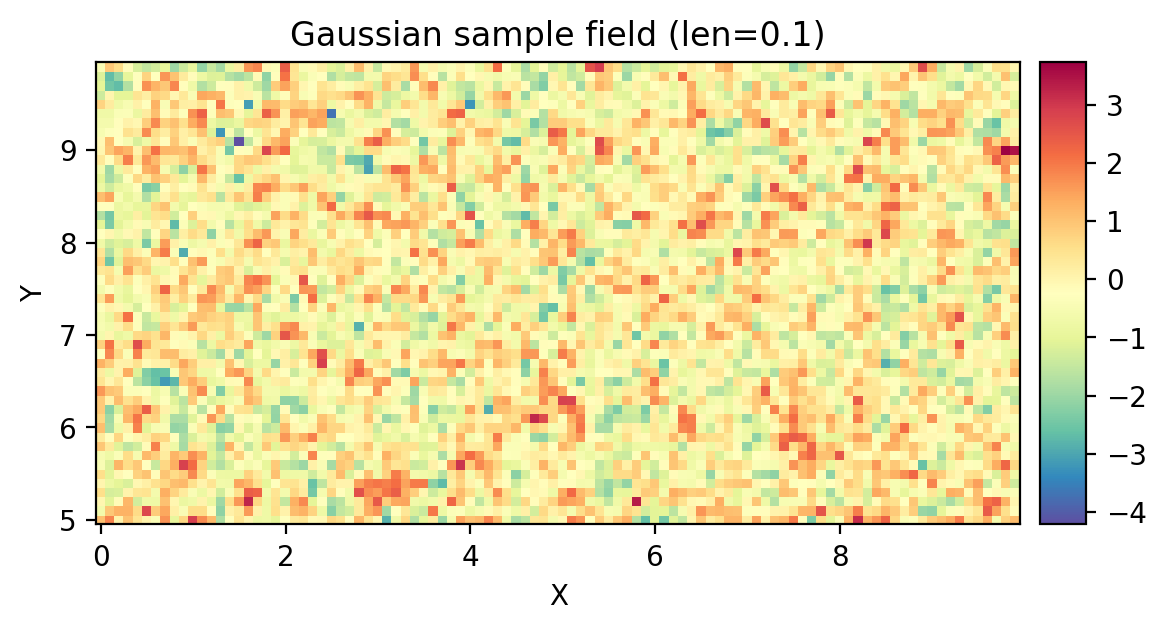

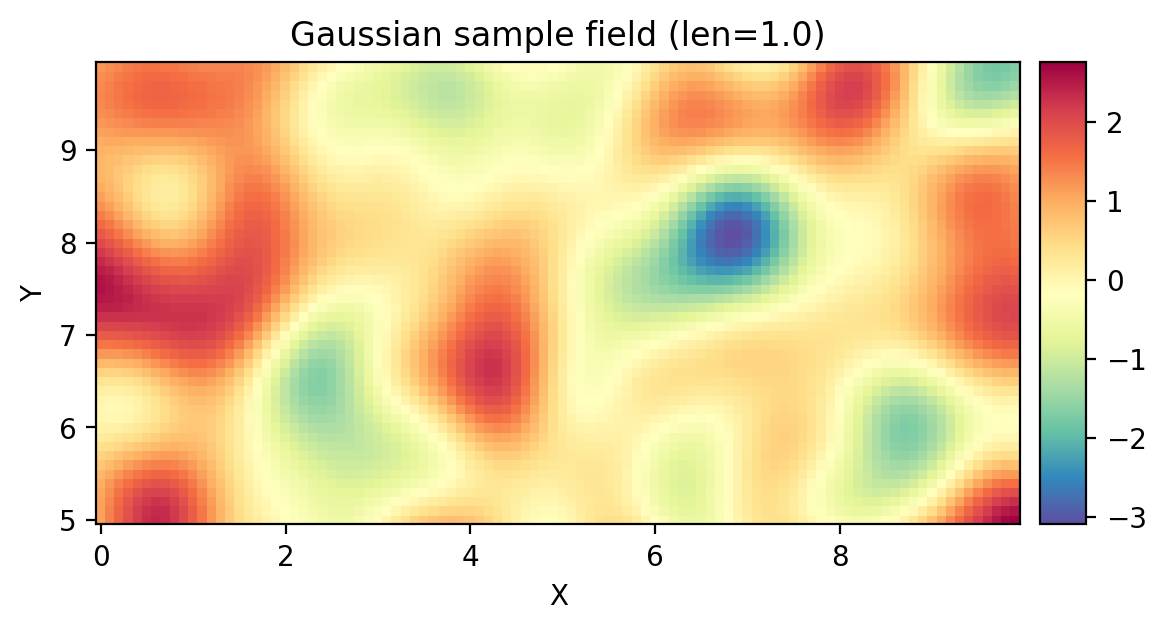

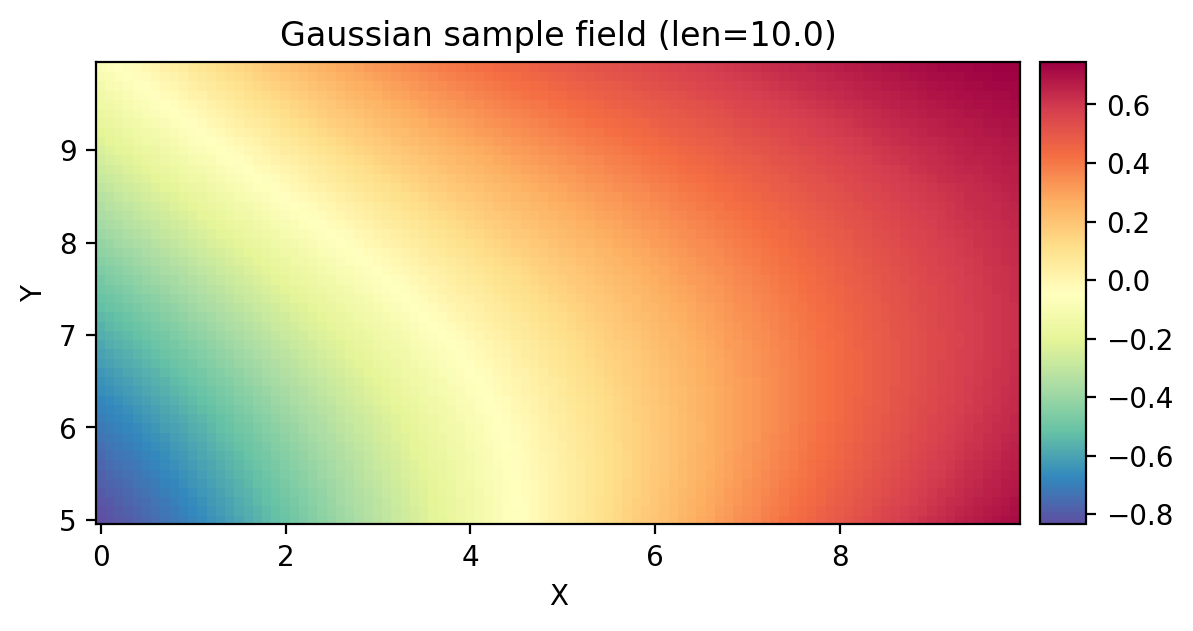

In [4]:
xy,xv,yv  = xy_grid(
    x_min=0,x_max=10,x_res=100,y_min=5,y_max=10,y_res=50) # [x_res*y_res x 2]
L         = xy.shape[0]
for len_val in [0.1,1.0,10.0]:
    K_prior       = kernel_se(xy,xy,hyp={'gain':1.0,'len':len_val})
    K_prior_chol  = np.linalg.cholesky(K_prior+1e-8*np.eye(L,L)) # [L x L]
    sample_vector = np.matmul(K_prior_chol,np.random.randn(L,1)) # [x_res*y_res x 1]
    sample_field  = sample_vector.reshape(xv.shape) # [y_res x x_res]
    # Sample GP field
    plt.figure(figsize=(8,3)); ax = plt.gca()
    im = plt.pcolor(xv,yv,sample_field,cmap=matplotlib.cm.Spectral_r)
    plt.title('Gaussian sample field (len=%.1f)'%(len_val),fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('X',fontsize=10); plt.ylabel('Y',fontsize=10)
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1))
    plt.show()

### Two-stage sampling  (sparse sampling + GRP interpolation)
Computation complexity with `pre-computing` kernel matricse becomes:
1. a matrix multiplication between 
$\mathbb{R}^{M \times M}$ and $\mathbb{R}^{M \times 1}$
2. a matrix multiplication between 
$\mathbb{R}^{N \times M}$ and $\mathbb{R}^{M \times 1}$

where $N$ is the number of dense points and $M$ is the number of sparse points. The pre-computation involves inverting an $M \times M$ matrix which is doable.

Sample from (10, 20), interpolate to (100, 200).


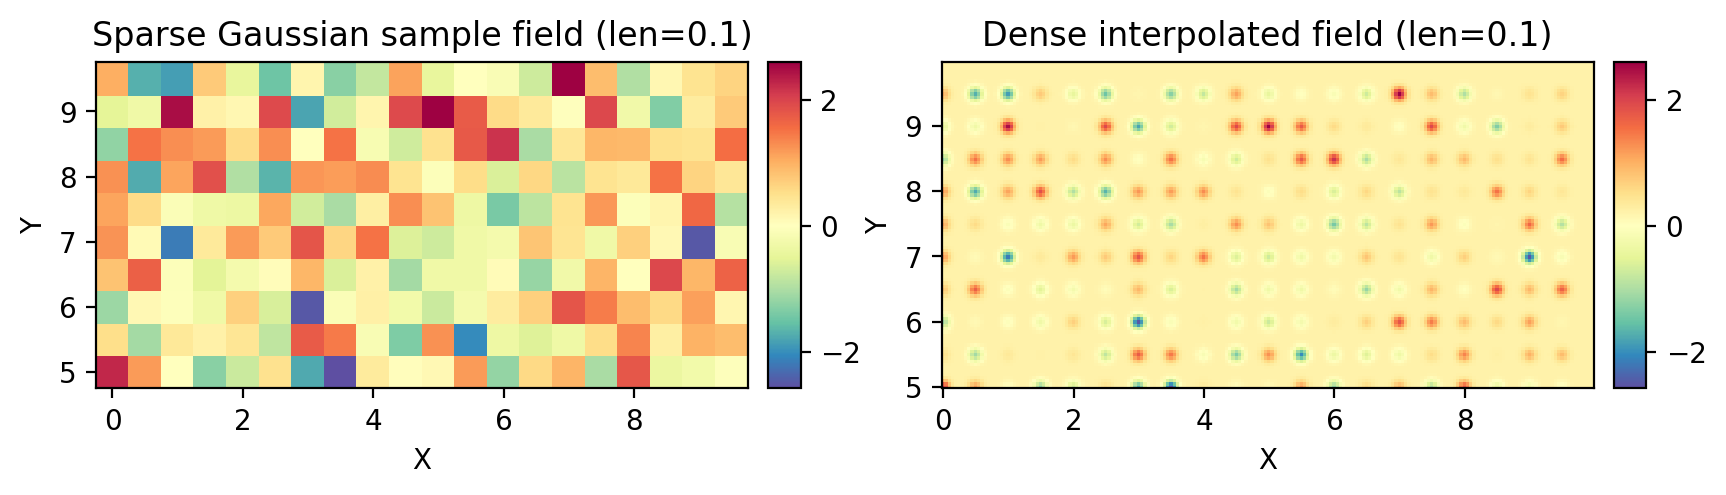

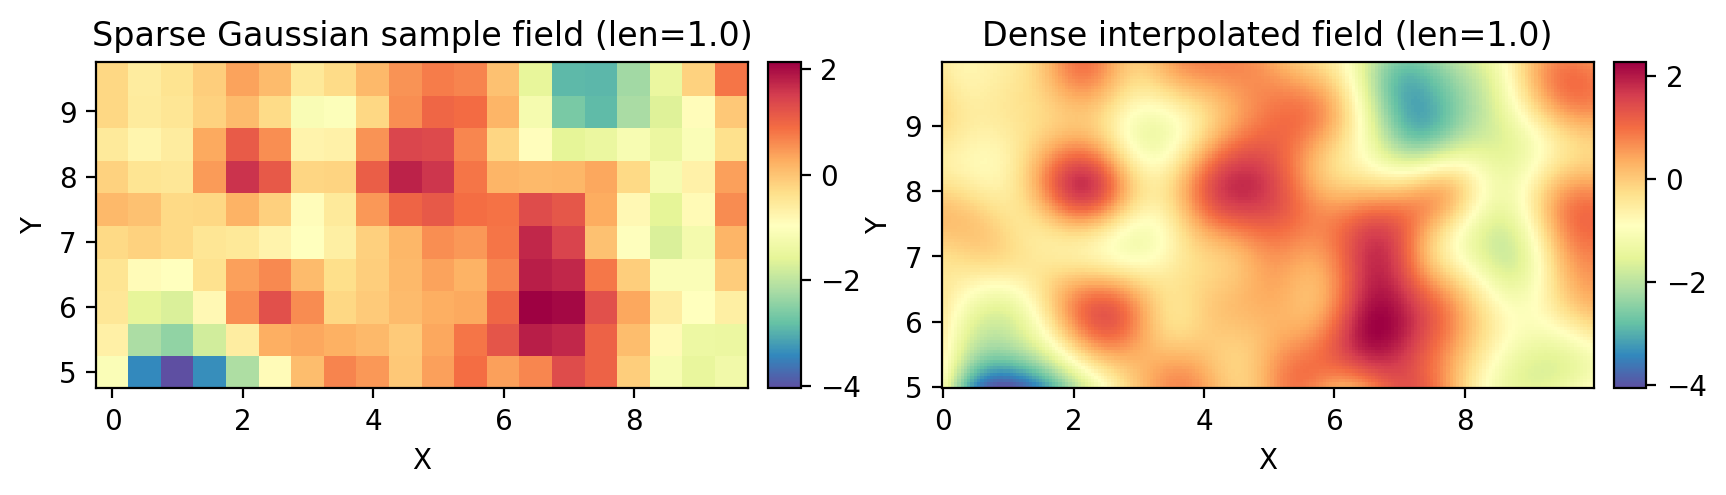

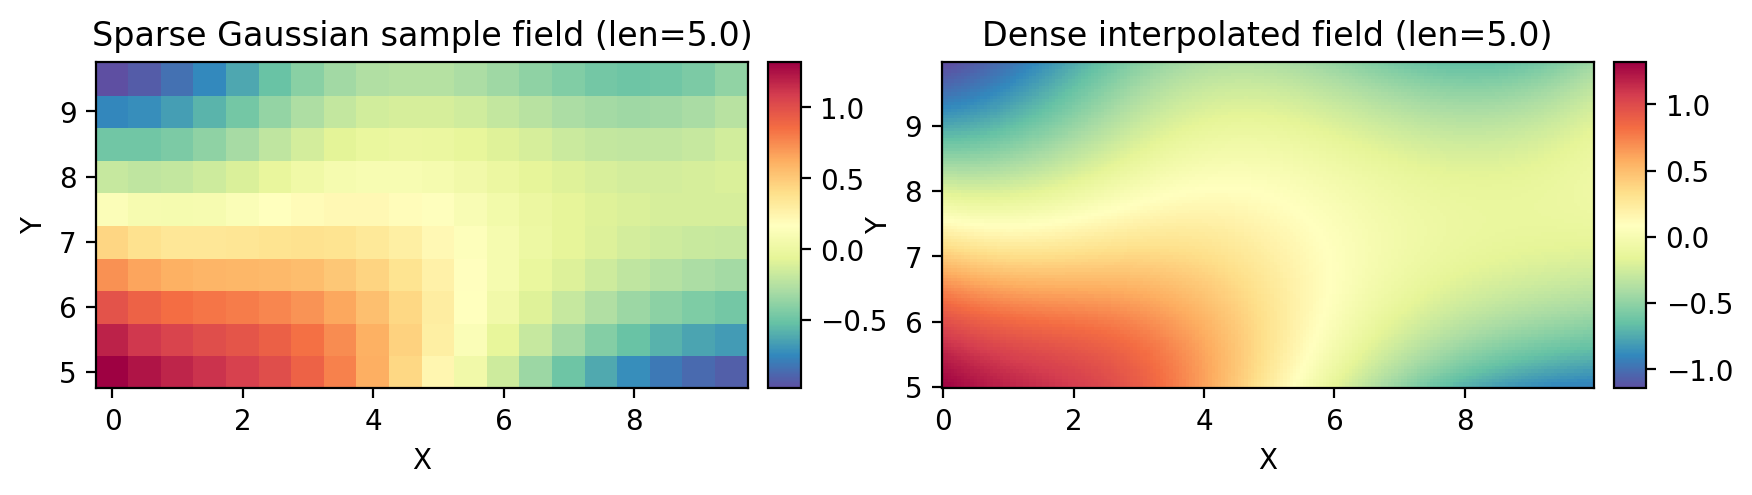

In [5]:
xy_sparse,xv_sparse,yv_sparse = xy_grid(
    x_min=0,x_max=10,x_res=20,y_min=5,y_max=10,y_res=10)
xy_dense,xv_dense,yv_dense = xy_grid(
    x_min=0,x_max=10,x_res=200,y_min=5,y_max=10,y_res=100)
L_sparse,L_dense = xy_sparse.shape[0],xy_dense.shape[0]
print ("Sample from %s, interpolate to %s."%(xv_sparse.shape,xv_dense.shape))
for len_val in [0.1,1.0,5.0]:
    # Sparse sampling
    hyp           = {'gain':1.0,'len':len_val}
    K_prior       = kernel_se(xy_sparse,xy_sparse,hyp=hyp) # [L_sparse x L_sparse]
    K_prior_chol  = np.linalg.cholesky(K_prior+1e-8*np.eye(L_sparse,L_sparse))
    sample_vector = np.matmul(K_prior_chol,np.random.randn(L_sparse,1)) # [x_res*y_res]
    sample_field  = sample_vector.reshape(xv_sparse.shape) # [y_res_sparse x x_res_sparse]
    # Dense interpolation
    K_data        = kernel_se(xy_sparse,xy_sparse,hyp=hyp) # [L_sparse x L_sparse]
    inv_K_data    = np.linalg.inv(K_data+1e-8*np.eye(L_sparse)) # [L_sparse x L_sparse]
    K_test_data   = kernel_se(xy_dense,xy_sparse,hyp=hyp) # [L_dense x L_sparse]
    Gamma_data    = K_test_data @ inv_K_data # [L_dense x L_sparse]
    mu_test       = Gamma_data @ (sample_vector-np.mean(sample_vector)) + \
        np.mean(sample_vector)
    dense_field   = mu_test.reshape(xv_dense.shape) # [y_res_dense x x_res_dense]
    # Plot sparse field
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); ax = plt.gca()
    im = plt.pcolor(xv_sparse,yv_sparse,sample_field,cmap=matplotlib.cm.Spectral_r)
    plt.title('Sparse Gaussian sample field (len=%.1f)'%(len_val),fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('X',fontsize=10); plt.ylabel('Y',fontsize=10)
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1))
    # Plot dense field
    plt.subplot(1,2,2); ax = plt.gca()
    im = plt.pcolor(xv_dense,yv_dense,dense_field,cmap=matplotlib.cm.Spectral_r)
    plt.title('Dense interpolated field (len=%.1f)'%(len_val),fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('X',fontsize=10); plt.ylabel('Y',fontsize=10)
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1))
    plt.show()